In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, MaxPooling1D, GlobalAveragePooling1D, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import compute_class_weight
from sklearn.utils import class_weight
from tensorflow.keras.metrics import Precision, Recall, AUC, SparseCategoricalAccuracy
import time
import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import movmus as mm
import movmus2 as mm2

import json

# loading model

In [11]:
model_name = 'M_20_1000'
model_folder = '.\\MODELS_1000'
plot_folder = '.\\PLOTS_1000'

In [3]:
model_name = 'BASE_SUBJ_CONTEXT_MODEL_EMG'
model_folder = '.\\MODELS_SC'
plot_folder = '.\\PLOTS_SC'

In [5]:
model_name = 'BASE_TASK_CONTEXT_NO_EMG_no_shape'
model_folder = '.\\MODELS_TC'
plot_folder = '.\\PLOTS_TC'

In [12]:
model = mm.load_model(model_folder, model_name)


Loading model from .\MODELS_1000\M_20_1000.keras
Num Layers: 11
----
----
Layer: conv1d_22
{
    "name": "conv1d_22",
    "trainable": true,
    "dtype": {
        "module": "keras",
        "class_name": "DTypePolicy",
        "config": {
            "name": "float32"
        },
        "registered_name": null
    },
    "filters": 16,
    "kernel_size": [
        5
    ],
    "strides": [
        1
    ],
    "padding": "valid",
    "data_format": "channels_last",
    "dilation_rate": [
        1
    ],
    "groups": 1,
    "activation": "relu",
    "use_bias": true,
    "kernel_initializer": {
        "module": "keras.initializers",
        "class_name": "GlorotUniform",
        "config": {
            "seed": null
        },
        "registered_name": null
    },
    "bias_initializer": {
        "module": "keras.initializers",
        "class_name": "Zeros",
        "config": {},
        "registered_name": null
    },
    "kernel_regularizer": null,
    "bias_regularizer": null,
  

# EMG data

In [13]:
train_data, val_data, test_data = mm.load_data_npz('EMG_1000_data.npz')

shape of training data: (2720, 1000, 7)
shape of validation data: (502, 1000, 7)
shape of test data: (661, 1000, 7)


# task data (shape)

In [13]:
test_data = mm.load_metadata_npz('task_context_test.npz')
test_data = test_data.iloc[:, 1:]
print(test_data.shape)

(661, 24)


In [14]:
test_data

,WEIGHT,SPAN_1,SPAN_2,SHAPE_SPAN_1_1.0,SHAPE_SPAN_1_2.0,SHAPE_SPAN_1_3.0,SHAPE_SPAN_1_4.0,SHAPE_SPAN_1_5.0,SHAPE_SPAN_1_6.0,SHAPE_SPAN_1_7.0,...,SHAPE_SPAN_2_7.0,SPAN_DH_1.0,SPAN_DH_2.0,ORI_PRODUCT_DH_1.0,ORI_PRODUCT_DH_2.0,ORI_PRODUCT_DH_3.0,ORI_PRODUCT_DH_4.0,TASK_HEIGHT_1.0,TASK_HEIGHT_2.0,TASK_HEIGHT_3.0
452,461.5,75.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
453,915.0,100.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
454,915.0,100.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
455,713.0,74.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
456,713.0,74.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3722,88.6,20.5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3723,100.6,20.5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3724,75.5,25.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3725,228.0,78.0,11.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


# task data (no shape)

In [22]:
test_data = mm.load_metadata_npz('task_no_shape_context_test.npz')
print(test_data.shape)

(661, 6)


In [23]:
test_data

,WEIGHT,SPAN_1,SPAN_2,TASK_HEIGHT_1.0,TASK_HEIGHT_2.0,TASK_HEIGHT_3.0
452,461.5,75.0,0.0,1.0,0.0,0.0
453,915.0,100.0,0.0,1.0,0.0,0.0
454,915.0,100.0,0.0,0.0,1.0,0.0
455,713.0,74.0,0.0,1.0,0.0,0.0
456,713.0,74.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...
3722,88.6,20.5,0.0,0.0,1.0,0.0
3723,100.6,20.5,0.0,0.0,1.0,0.0
3724,75.5,25.0,0.0,0.0,1.0,0.0
3725,228.0,78.0,11.0,0.0,1.0,0.0


# subject data

In [4]:
test_data = mm.load_metadata_npz('subject_context_test.npz')


print(test_data.shape)

(661, 6)


In [5]:
test_data = test_data.iloc[:, 1:]
test_data

,GENDER,AGE,HL,FOREARM,HEIGHT
452,0.0,0.030303,0.571429,0.615385,0.59375
453,0.0,0.030303,0.571429,0.615385,0.59375
454,0.0,0.030303,0.571429,0.615385,0.59375
455,0.0,0.030303,0.571429,0.615385,0.59375
456,0.0,0.030303,0.571429,0.615385,0.59375
...,...,...,...,...,...
3722,0.0,0.515152,0.457143,0.769231,0.46875
3723,0.0,0.515152,0.457143,0.769231,0.46875
3724,0.0,0.515152,0.457143,0.769231,0.46875
3725,0.0,0.515152,0.457143,0.769231,0.46875


# labels

In [14]:
train_labels, val_labels, test_labels = mm.load_data_npz('labels.npz')

shape of training data: (2720, 2)
shape of validation data: (502, 2)
shape of test data: (661, 2)


# evaluation

In [15]:
evaluation = model.evaluate(test_data, test_labels, verbose=0)
print(evaluation)

[0.6114667057991028, 0.7912254333496094, 0.7912254333496094, 0.7912254333496094]


In [16]:
print(model.metrics_names)

['loss', 'compile_metrics']


In [17]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report, confusion_matrix

y_pred_probs = model.predict(test_data)  
y_pred = np.argmax(y_pred_probs, axis=1) 

y_true = np.argmax(test_labels, axis=1)  
# Calcular métricas adicionales
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
print(f'Loss: {evaluation[0]}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'Accuracy: {accuracy}')

print(classification_report(y_true, y_pred))

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Loss: 0.6114667057991028
Precision: 0.7921348314606742
Recall: 0.815028901734104
Accuracy: 0.7912254160363086
              precision    recall  f1-score   support

           0       0.79      0.77      0.78       315
           1       0.79      0.82      0.80       346

    accuracy                           0.79       661
   macro avg       0.79      0.79      0.79       661
weighted avg       0.79      0.79      0.79       661



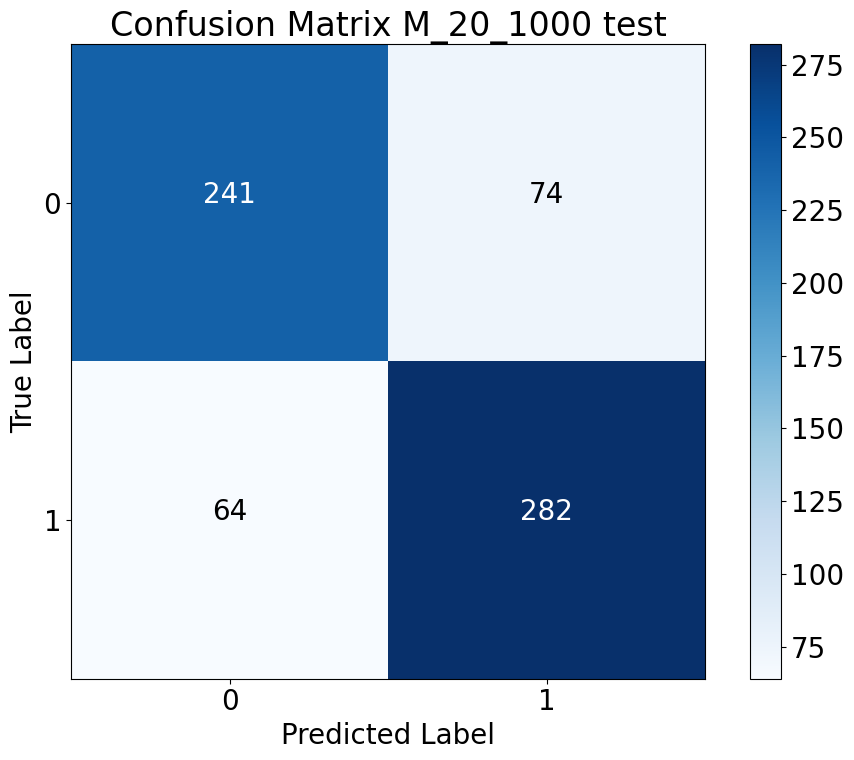

In [18]:
plt.rcParams.update({'font.size': 20})  # You can change the number to make it bigger/smaller
# 
#  Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
cmap = plt.cm.Blues
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion Matrix ' + model_name + ' test')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_true)))  # this adapts to the number of classes dynamically
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)

# Labeling the axes
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations inside the squares
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.savefig(f'{plot_folder}\\CM_{model_name}_test.png')

plt.show()
